In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import helper
import os
from matplotlib.lines import Line2D

%load_ext autoreload
%autoreload 2

mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
exp_measures = pd.read_csv("../data/measures.csv")
exp_data = pd.read_csv("../data/processed_data.csv", index_col=["subj_id", "session", "route", "intersection_no"])
model_params = pd.read_csv("../model_fit_results/model_1/best_fit_parameters/full_data_parameters_fitted.csv")
simulation_results_path = "../model_fit_results/model_1/simulation_results/"
model_measures_all_conditions = pd.read_csv(os.path.join(simulation_results_path, "full_data_measures.csv"))

# Main paper figures

### Model diagram

In [36]:
def get_trace(t, dt, tta, d, model_params):  
    noise = np.random.randn(len(t))
    drift = model_params["alpha"]*(tta+ model_params["beta"]*d - model_params["theta"])
    dx = drift * simulation_params["dt"] +  model_params["noise"] * noise * np.sqrt(simulation_params["dt"])
    x = np.append([0], np.cumsum(dx)[:-1])    
    boundary = model_params["b_0"]/(1+np.exp(-model_params["k"]*(tta-model_params["tta_crit"])))
    response_time_idx = np.where(abs(x)>boundary)
    if len(response_time_idx[0])>0:
        return(x[:response_time_idx[0][0]+1])
    else:
        return(x)
    
def generate_model_traces(t, dt, tta, d, model_params):
    is_two_correct = False
    is_rt_ok = False
    while not(is_two_correct) or not(is_rt_ok):
        trials = [get_trace(t, dt, tta, d, model_params) for i in range(3)]
        is_two_correct = (np.sum([1 if x[-1]>0 else 0 for x in trials]) == 2)
        rts = [model_params["ndt_location"]+len(trial)*dt for trial in trials]
        is_rt_ok = all([(rt>0.4) & (rt<0.7) for rt in rts])
    pd.DataFrame(trials).to_csv("ddm_traces.csv")

In [37]:
def plot_model_traces(model_params, simulation_params, generate_new=False):
    colors = {"go": "#4052ac", "stay": "#e6263d", "equation": "#50596A"}
    condition = {"tta": 6, "d": 120}
    dt = simulation_params["dt"]
    t = np.arange(0, simulation_params["duration"], dt)
    d = condition["d"] - (condition["d"] / condition["tta"])*t
    tta = condition["tta"] - t
    ndt = model_params["ndt_location"]

    if generate_new:
        generate_model_traces(t, dt, tta, d, model_params)        
    trials = [x[1][~x[1].isna()].values[1:] for x in pd.read_csv("ddm_traces.csv").iterrows()]
    
    fig, (ax_rate, ax) = plt.subplots(2, 1, figsize=(8,6), gridspec_kw={"height_ratios": [1, 3]}, dpi=150, sharex=True)
    
    for x in trials:
        color = colors["go"] if x[-1]>0 else colors["stay"]
        ax.plot(t[:len(x)]+ndt, x, lw=1.0, alpha=0.4, color=color)
        ax.plot(t[len(x)]+ndt, x[-1], ls="", alpha=0.8, marker="o", ms=4, color=color)

    for tta_condition in [4, 6]:
        boundary = model_params["b_0"]/(1+np.exp(-model_params["k"]*(tta_condition-t-model_params["tta_crit"])))
        ax.plot(t+ndt, boundary, ls="--", color="gray", alpha=0.6)
        ax.plot(t+ndt, -boundary, ls="--", color="gray", alpha=0.6)
        ax.text(0.78, 0.3+0.15*(tta_condition-4), r"TTA$|_{t=0}$=%is" % (tta_condition),
                color=colors["equation"], alpha=0.6, fontsize=16)
        
        # Add extra markers to illustrate what would happen if the boundary was lower (TTA condition is 4s)
        if tta_condition==4:
            for x in trials:
                color = colors["go"] if x[-1]>0 else colors["stay"]
                response_time_idx = np.where(abs(x)>boundary[:len(x)])[0][0]
                ax.plot(t[response_time_idx]+ndt, x[response_time_idx], ls="", alpha=0.5,
                        marker="o", ms=4, color=color)

    ax.text(0.01, 0.04, "Non-decision time", color=colors["equation"], fontsize=13)
    ax.plot([0, ndt], [0,0], lw=1, color=colors["equation"])
    ax.vlines(x=[0, ndt-0.002], ymin=-0.02, ymax=0.09, ls="--", color=colors["equation"], lw=1)

    ax.annotate("", xy=(ndt,0), xytext=(ndt+0.2, 0.15),
                 arrowprops=dict(arrowstyle="<-", connectionstyle="arc3", color=colors["equation"], linewidth=2))
    ax.text(0.43, 0.02, r"$dx = \alpha(TTA + \beta d - \theta_{crit}) dt + dW$", color=colors["equation"], fontsize=16)
    
    ax.text(0.47, 0.6, "Go", color=colors["go"], alpha=0.7, fontsize=16)
    ax.text(0.47, -0.65, "Stay", color=colors["stay"], alpha=0.7, fontsize=16)

    ax.set_xlabel(r"Time $t$", fontsize=14)
    ax.set_ylabel(r"Accumulated evidence $x$", fontsize=14)
    ax.set_yticks([-0.6, -0.3, 0, 0.3, 0.6])
    ax.set_ylim((-0.7, 0.7))
   
    ax_rate.plot(t+ndt, tta+model_params["beta"]*d, color="#50596A", alpha=0.8)
    ax_rate.axhline(model_params["theta"], color="grey", alpha=0.6, ls="--", xmin=0.01, xmax=0.99)
    ax_rate.set_ylabel(r"$TTA + \beta d$", fontsize=16)
    ax_rate.set_xlim((0,1))
    ax_rate.set_ylim((8,12))
    ax_rate.text(0.05, 9.5, r"$\theta_{crit}$", color="grey", alpha=0.7, fontsize=16)

    sns.despine(offset=2, trim=True)
    plt.tight_layout()

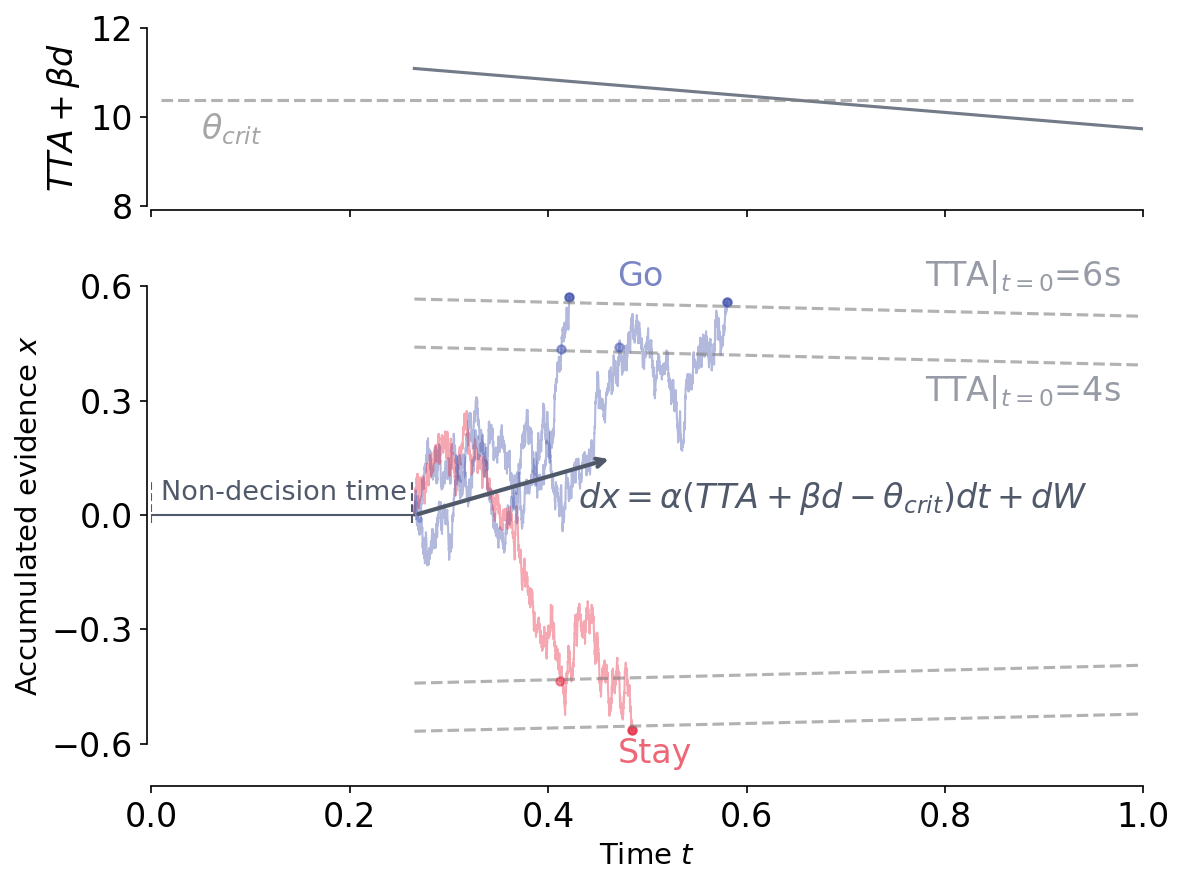

In [38]:
all_subj_params = model_params[model_params.subj_id=="all"].to_dict("records")[0]
all_subj_params["ndt_location"] -= 0.1
all_subj_params["theta"] += 0.5
simulation_params = {"dt": 0.0001, "duration": 1}

plot_model_traces(all_subj_params, simulation_params, generate_new=False)
plt.savefig("../output/fig_model_diagram.pdf", bbox_inches="tight")

### Trial timeline

In [39]:
traj_id = (129, 1, 2, 5)
traj = exp_data.loc[traj_id].reset_index()

In [40]:
def plot_traj(traj, ax=None):
    color = "#50596A"
    font_size = 14
    ms = 12
    lw = 3
    
    idx_bot_spawn = int(traj.iloc[0].idx_bot_spawn)
    idx_response = int(traj.iloc[0].idx_response)
    idx_min_distance = int(traj.iloc[0].idx_min_distance)
    tta = int(traj.iloc[0].tta_condition)
    d = int(traj.iloc[0].d_condition)
    
    traj.loc[:, "t"] -= traj.t.values[idx_bot_spawn]
    
    fig, axes = plt.subplots(4, 1, figsize=(8,6), dpi=150, sharex=True)
    axes[0].plot(traj.t, traj.ego_v, color=color, lw=lw)
    axes[0].plot(traj.t[idx_bot_spawn], traj.ego_v[idx_bot_spawn], color=color, ls="", marker="o", ms=ms)
    axes[0].plot(traj.t[idx_response], traj.ego_v[idx_response], color=color, ls="", marker="x", ms=ms)
    axes[0].set_ylabel("Velocity, m/s", fontsize=font_size)
    axes[0].set_ylim((-1, 7))
    
    for x in [traj.t[idx_bot_spawn], traj.t[idx_response]]:
        axes[0].axvline(x=x, ymin=-0.3, ymax=0.5, c=color, ls="--", clip_on=False)
        axes[1].axvline(x=x, ymin=-0.2, ymax=1, c=color, ls="--", clip_on=False)
    
    axes[1].annotate(text="", xy=(traj.t[idx_bot_spawn], 70), xytext=(traj.t[idx_response], 70),
                     arrowprops=dict(arrowstyle="<->", color="0.5"))
    axes[1].text(.21, .79, "Response time (RT)", transform=axes[1].transAxes, fontsize=font_size)
    
#     throttle_brake = traj.throttle-traj.brake
    axes[1].plot(traj.t, 100*traj.throttle, color=color, lw=lw)
    axes[1].plot(traj.t[idx_bot_spawn], 100*traj.throttle[idx_bot_spawn], color=color, ls="", marker="o", ms=ms)
    axes[1].plot(traj.t[idx_response], 100*traj.throttle[idx_response], color=color, ls="", marker="x", ms=ms)
    axes[1].set_ylabel("Gas pedal, %", fontsize=font_size)
    axes[1].set_ylim((-20, 120))
    axes[1].set_yticks([0, 100])

    axes[2].plot(traj.t[idx_bot_spawn:], traj.d_ego_bot[idx_bot_spawn:], color=color, lw=lw)
    axes[2].plot(traj.t[idx_bot_spawn], traj.d_ego_bot[idx_bot_spawn], color=color, ls="", marker="o", ms=ms)
    axes[2].plot(traj.t[idx_response], traj.d_ego_bot[idx_response], color=color, ls="", marker="x", ms=ms)
    axes[2].set_ylabel("Distance, m", fontsize=font_size)
    axes[2].set_ylim((80, 122))

    axes[3].plot(traj.t[idx_bot_spawn:], traj.tta[idx_bot_spawn:], color=color, lw=lw)
    axes[3].plot(traj.t[idx_bot_spawn], traj.tta[idx_bot_spawn], color=color, ls="", marker="o",
                 label="Velocity$=0$: oncoming car appears", ms=ms)
    axes[3].plot(traj.t[idx_response], traj.tta[idx_response], color=color, ls="", marker="x",
                 label="Gas pedal$>0$: decision is made", ms=ms)
    axes[3].set_ylabel("TTA, s", fontsize=font_size)
    axes[3].set_ylim((3.5, 6.5))
    axes[3].set_yticks([4, 5, 6])

    axes[3].set_xlim((-0.3, 1.5))
    axes[3].set_xticks(np.arange(0, 1.4, 0.3))
    
    axes[3].set_xlabel("Time $t$, s", fontsize=font_size)

    legend = fig.legend(loc="upper left", fontsize=font_size, bbox_to_anchor=(0.4, 1.05), frameon=False)
#     legend.get_title().set_fontsize("16")
    sns.despine(offset=0)
    plt.tight_layout()

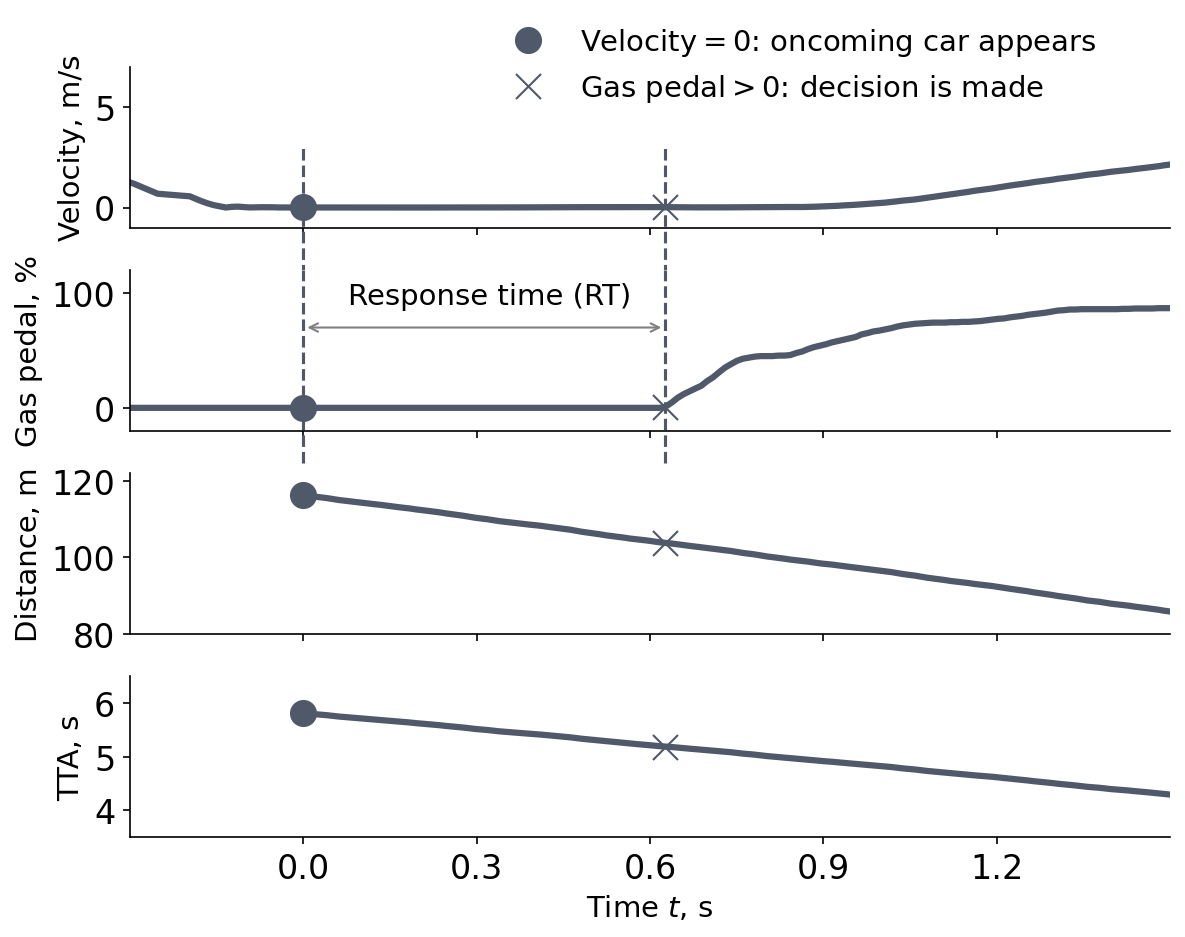

In [41]:
plot_traj(traj)
plt.savefig("../output/fig_trial_timeline.pdf", bbox_inches="tight")

### Model fit against data

In [42]:
    
def plot_compare_model_exp(var, exp_data, model_measures, ylabel):  
    #because of the bug in matplotlib/pandas, we need to convert subj_id to str to avoid warnings
    exp_data = exp_data.astype({"subj_id": str})
    # group_rt_means = pd.read_csv("rt_group_means.csv")
    model_measures = model_measures[(model_measures.tta_condition>=4.0) & (model_measures.tta_condition<=6.0)]

    d_conditions = [90, 120, 150]
    markers=["o", "s", "^"]
    colors = [plt.cm.viridis(r) for r in np.linspace(0.1,0.7,len(d_conditions))]
    
    subjects = model_measures.subj_id.unique()
    
    fig, axes = plt.subplots(4, 5, figsize=(14,12), sharex=True, sharey=True)

    axes_to_plot = np.concatenate([axes[:,:4].flatten(), [axes[0,4]]])
    for subj_id, subj_idx, ax in zip(subjects, range(len(subjects)), axes_to_plot):
        ax.set_title("All participants" if subj_id=="all" else "P%s" % (subj_idx+1), fontsize=16)
        for d_condition, color, marker in zip(d_conditions, colors, markers):
            model_subj_d_measures = model_measures[(model_measures.subj_id==subj_id) 
                                                   & (model_measures.d_condition==d_condition)]         

            # Model
            ax.plot(model_subj_d_measures.tta_condition, model_subj_d_measures[var], color=color, label=d_condition)

            # Data
            if var=="is_go_decision":
                # for all subjects, use scipy sem estimates, since we average over continuous measures (p_go)
                if subj_id=="all":
                    helper.plot_all_subj_p_go(ax, exp_data, d_condition, marker, color)
                # for individual subjects, use binomial proportion sem estimates, since we average over binary measures (is_go_decision)
                else:
                    helper.plot_subj_p_go(ax, exp_data, d_condition, subj_id, marker, color)
            elif var=="RT":
                helper.plot_subj_rt(ax, exp_data, d_condition, subj_id, marker, color)
                ax.set_yticks([0.3, 0.6, 0.9, 1.2])
            else:
                raise(ValueError)

        ax.legend().remove()
        ax.set_xlabel("")
        ax.set_ylabel("")

    sns.despine(offset=5, trim=True)

    for ax in axes[1:,4]:
        fig.delaxes(ax)

    plt.tight_layout()

    legend_elements = ([Line2D([0], [0], color=color, marker=marker, ms=9, lw=0, label="Data, d=%im" % (d_condition))
                       for d_condition, color, marker in zip(d_conditions, colors, markers)] 
                       + [Line2D([0], [0], color="grey", label="Model")])

    fig.legend(handles=legend_elements, loc="center", bbox_to_anchor=(0.9, 0.62), fontsize=16, frameon=False)

    fig.text(0.35, -0.02, "Time-to-arrival (TTA), s", fontsize=18)
    fig.text(-0.02, 0.39, ylabel, fontsize=18, rotation=90)

D:\source\evidence_accumulation_in_gap_acceptance\data_and_model_analysis\helper.py:95: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  between_subj_mean = exp_measures[(exp_measures.d_condition == d_condition)].groupby(
D:\source\evidence_accumulation_in_gap_acceptance\data_and_model_analysis\helper.py:95: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  between_subj_mean = exp_measures[(exp_measures.d_condition == d_condition)].groupby(
D:\source\evidence_accumulation_in_gap_acceptance\data_and_model_analysis\helper.py:95: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated.

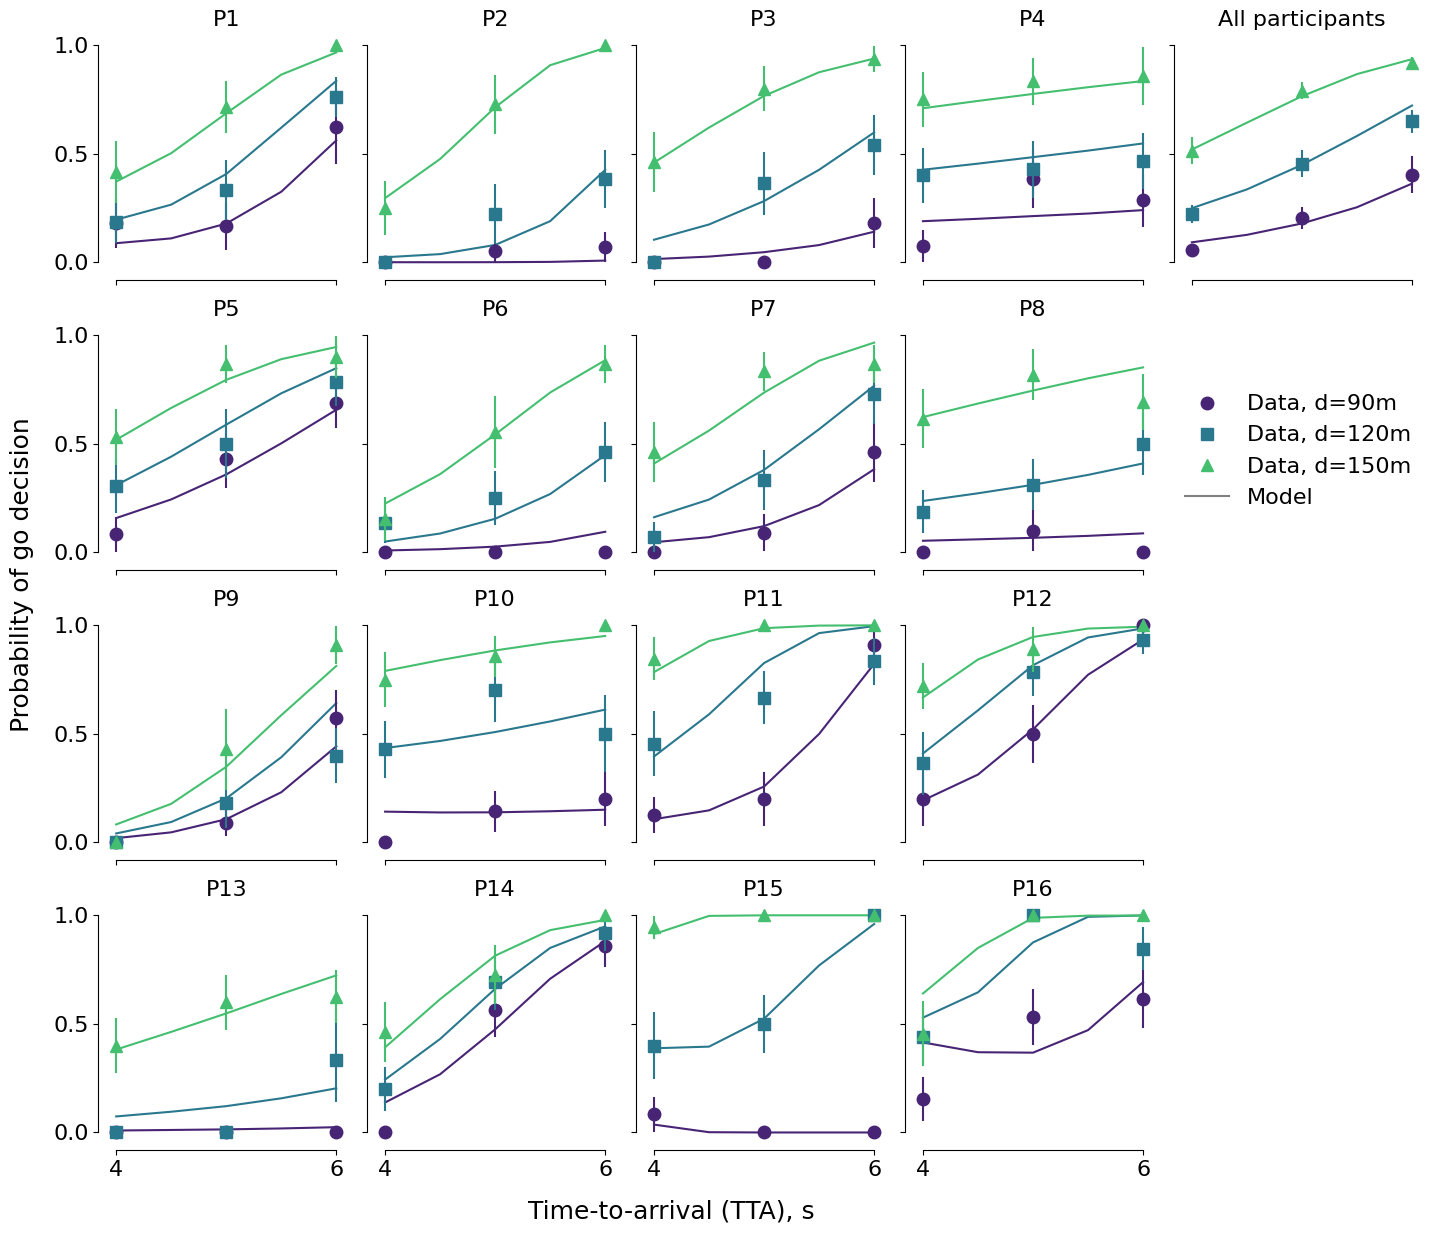

In [43]:
plot_compare_model_exp("is_go_decision", exp_measures, model_measures_all_conditions, "Probability of go decision")
plt.savefig("../output/fig_p_go.pdf", bbox_inches="tight")

D:\source\evidence_accumulation_in_gap_acceptance\data_and_model_analysis\helper.py:112: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  between_subj_mean = exp_measures[
D:\source\evidence_accumulation_in_gap_acceptance\data_and_model_analysis\helper.py:112: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  between_subj_mean = exp_measures[
D:\source\evidence_accumulation_in_gap_acceptance\data_and_model_analysis\helper.py:112: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select onl

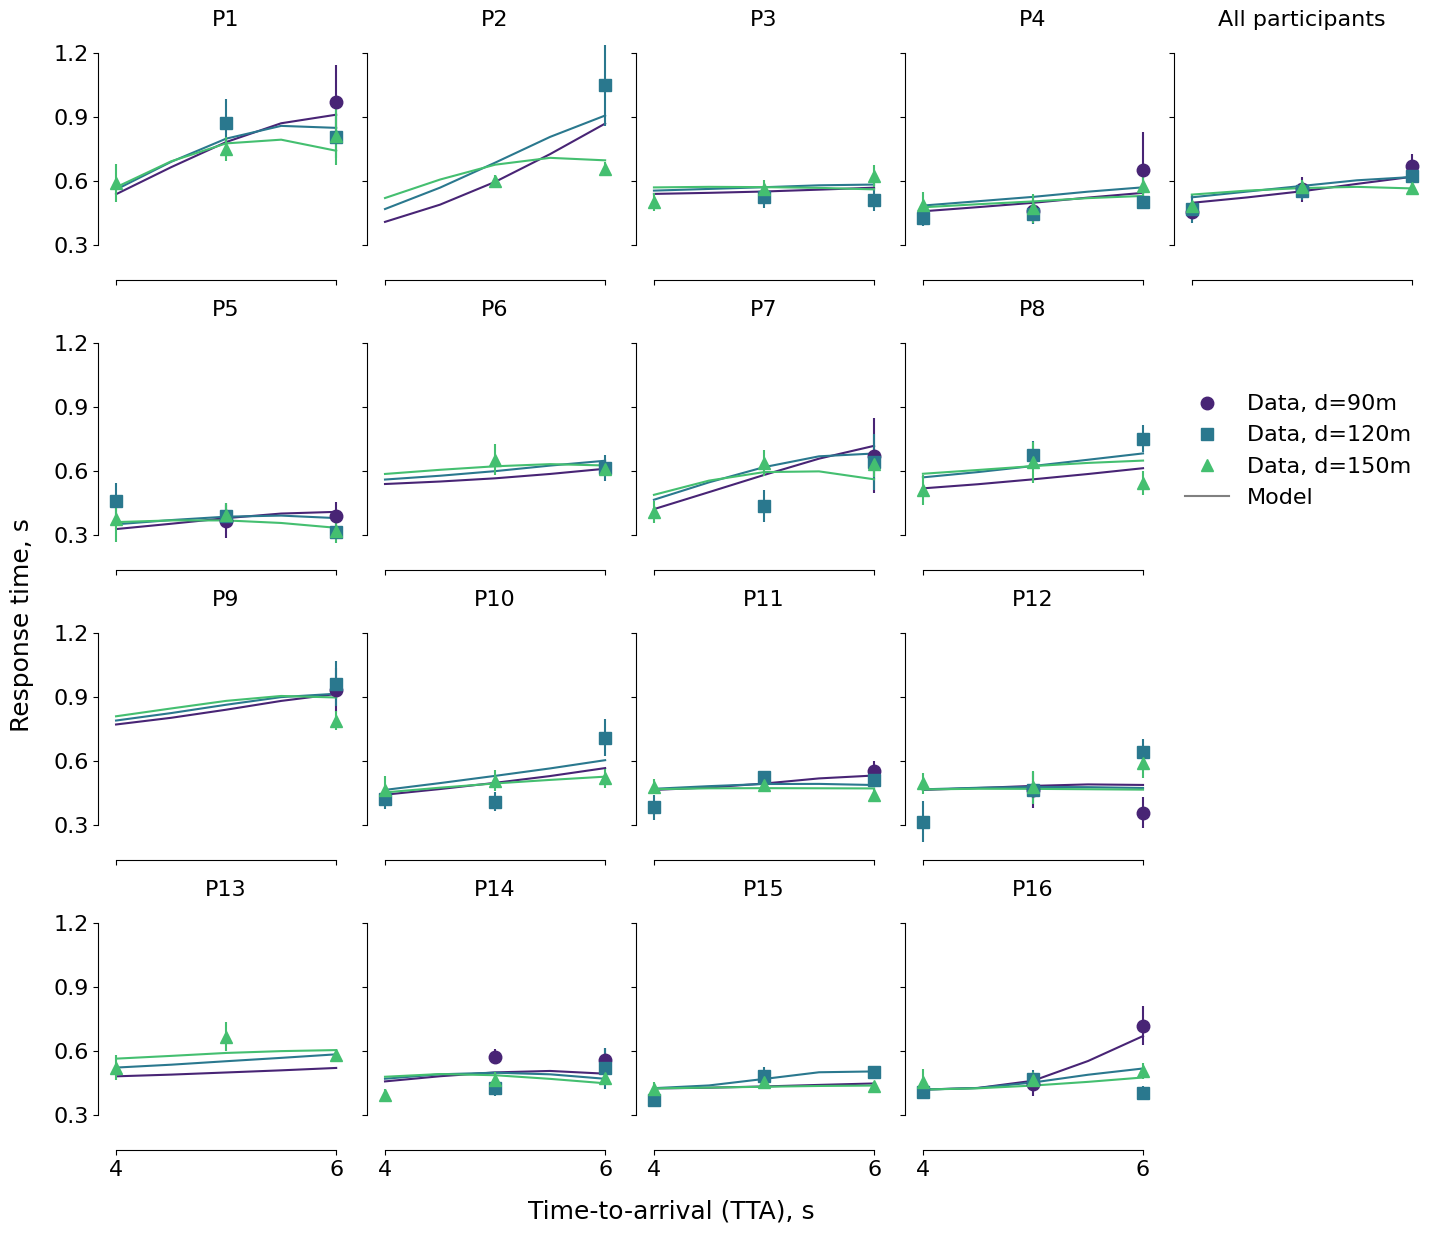

In [44]:
plot_compare_model_exp("RT", exp_measures, model_measures_all_conditions, "Response time, s")
plt.savefig("../output/fig_RT.pdf", bbox_inches="tight")

### RT distributions

C:\Users\azgonnikov\AppData\Local\Temp\ipykernel_23188\1619404839.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  model_rts = pd.read_csv(os.path.join(simulation_results_path, "full_data_rt_cdf.csv"))


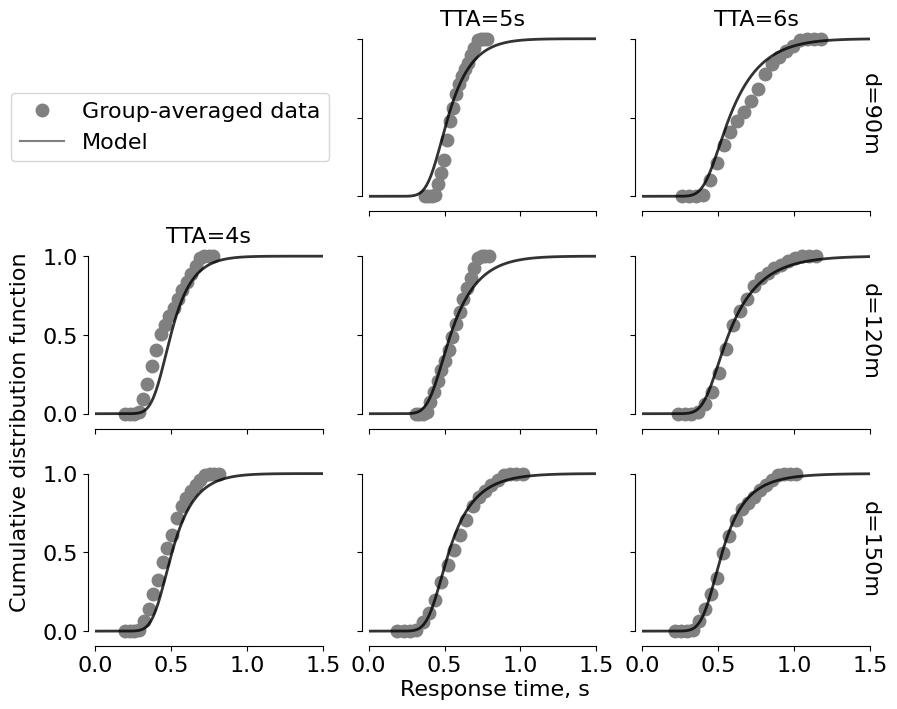

In [45]:
fig, axes = plt.subplots(3, 3, figsize=(10,8), sharex=True, sharey=True)

model_rts = pd.read_csv(os.path.join(simulation_results_path, "full_data_rt_cdf.csv"))
helper.plot_vincentized_dist(fig, axes, exp_measures, model_rts)
legend_elements = ([Line2D([0], [0], color="grey", marker="o", ms=9, lw=0, label="Group-averaged data"),
                    Line2D([0], [0], color="grey", label="Model")])
fig.legend(handles=legend_elements, loc="center", bbox_to_anchor=(0.2, 0.75), fontsize=16, frameon=True)

# fig.suptitle("Model %i" % model_no)
plt.savefig("../output/fig_RT_dist.pdf", bbox_inches="tight")

# Model comparison

D:\source\evidence_accumulation_in_gap_acceptance\data_and_model_analysis\helper.py:95: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  between_subj_mean = exp_measures[(exp_measures.d_condition == d_condition)].groupby(
D:\source\evidence_accumulation_in_gap_acceptance\data_and_model_analysis\helper.py:112: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  between_subj_mean = exp_measures[
D:\source\evidence_accumulation_in_gap_acceptance\data_and_model_analysis\helper.py:95: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to

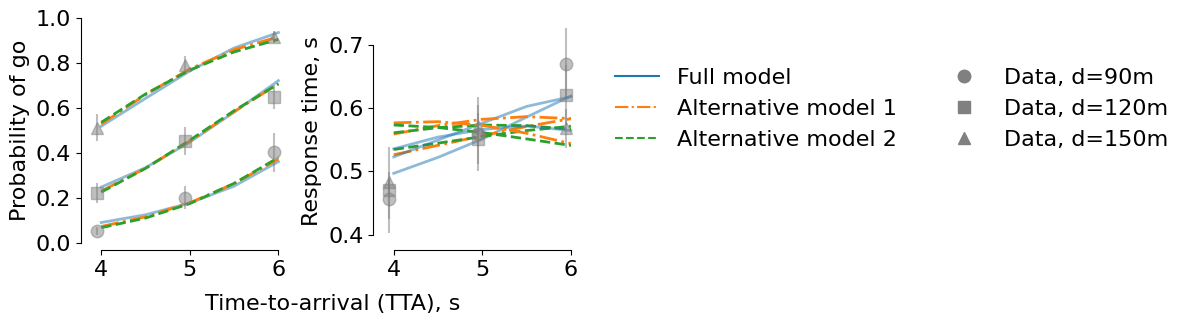

In [46]:
def plot_compare_models_all_subj(exp_data):
    all_models_simulation_results_path = "../model_fit_results/model_%i/simulation_results/%s_measures.csv"

    #because of a bug in matplotlib/pandas, we need to convert subj_id to str to avoid warnings
    exp_data = exp_data.reset_index()
    exp_data = exp_data.astype({"subj_id": str})

    model_measures = [pd.read_csv(all_models_simulation_results_path % (model_no, "full_data")) for model_no in [1, 2, 3]]
    model_measures = [df[(df.tta_condition>=4.0) & (df.tta_condition<=6.0)] for df in model_measures]

    d_conditions = [90, 120, 150]
    markers = ["o", "s", "^"]
    marker_size=9
    marker_offset = 0.05
    model_names = ["Full model", "Alternative model 1", "Alternative model 2"]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3), sharex=True, sharey=False)

    for d_condition, marker in zip(d_conditions, markers):
        helper.plot_all_subj_p_go(ax1, exp_data, d_condition, marker, color="grey", ms=marker_size, alpha=0.5, marker_offset=-marker_offset)
        helper.plot_subj_rt(ax2, exp_data, d_condition, "all", marker, color="grey", ms=marker_size, alpha=0.5, marker_offset=-marker_offset)

        for model_no, ls in zip([1, 2, 3], ["-", "-.", "--"]):
            model_subj_d_measures = model_measures[model_no-1][(model_measures[model_no-1].subj_id=="all")
                                                   & (model_measures[model_no-1].d_condition==d_condition)]
            ax1.plot(model_subj_d_measures.tta_condition, model_subj_d_measures["is_go_decision"], lw=2, ls=ls, color="C%i" % (model_no-1), alpha=0.5 if (model_no == 1) else 1.0)
            ax2.plot(model_subj_d_measures.tta_condition, model_subj_d_measures["RT"], lw=2, ls=ls, color="C%i" % (model_no-1), alpha=0.5 if (model_no == 1) else 1.0)

    ax1.set_ylim([0.0, 1.0])
    ax1.set_ylabel("Probability of go", fontsize=16)
    ax2.set_ylabel("Response time, s", fontsize=16)
    # ax2.set_yticks([0.3, 0.6, 0.9, 1.2])
    # ax1.xaxis.set_tick_params(labelsize=16)
    # ax2.xaxis.set_tick_params(labelsize=16)
    # ax1.yaxis.set_tick_params(labelsize=16)
    # ax2.yaxis.set_tick_params(labelsize=16)

    ax1.set_xticks([4, 5, 6])
    ax2.set_xticks([4, 5, 6])

    sns.despine(offset=5, trim=True)

    plt.tight_layout()

    legend_elements = ([Line2D([0], [0], ls=ls, color="C%i" % (model_no-1), label=model_names[model_no-1])#label="Model %i" % (model_no))
                          for model_no, ls in zip([1, 2, 3], ["-", "-.", "--"])] +
                       [Line2D([0], [0], color="grey", marker=marker, ms=9, lw=0, label="Data, d=%im" % (d_condition))
                       for d_condition, marker in zip(d_conditions, markers)])
    fig.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1.0, 0.62), fontsize=16, frameon=False, ncols=2)

    fig.text(0.35, -0.05, "Time-to-arrival (TTA), s", fontsize=16)
    # fig.text(-0.02, 0.39, ylabel, fontsize=18, rotation=90)
plot_compare_models_all_subj(exp_measures)
plt.savefig("../output/fig_model_comparison.pdf", bbox_inches="tight")

### Model cross-validation

In [47]:
model_measures_cv = pd.read_csv(os.path.join(simulation_results_path, "cross_validation_8_measures.csv"))

D:\source\evidence_accumulation_in_gap_acceptance\data_and_model_analysis\helper.py:95: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  between_subj_mean = exp_measures[(exp_measures.d_condition == d_condition)].groupby(
D:\source\evidence_accumulation_in_gap_acceptance\data_and_model_analysis\helper.py:112: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  between_subj_mean = exp_measures[
D:\source\evidence_accumulation_in_gap_acceptance\data_and_model_analysis\helper.py:95: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to

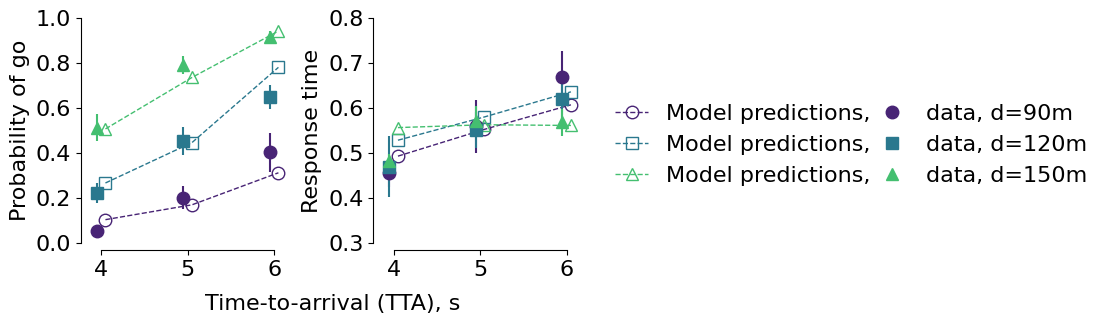

In [48]:
helper.plot_cross_validation(exp_measures, model_measures_cv)
plt.savefig("../output/fig_cross_validation.pdf", bbox_inches="tight")

# Summary statistics

In [49]:
exp_measures[exp_measures.is_go_decision].groupby(["tta_condition", "d_condition"]).size()

tta_condition  d_condition
4.0            90.0            11
               120.0           48
               150.0          114
5.0            90.0            46
               120.0           88
               150.0          163
6.0            90.0            80
               120.0          141
               150.0          192
dtype: int64